# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
#!pip install prophet   # already installed

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv"
).dropna()

df_mercado_trends['Date'] = pd.to_datetime(df_mercado_trends['Date'],utc=True)

df_mercado_trends.reset_index()
df_mercado_trends.set_index('Date',inplace=True)

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())
df_mercado_trends.dtypes


<ipython-input-3-6ae291c26b2b>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends['Date'] = pd.to_datetime(df_mercado_trends['Date'],utc=True)


,Search Trends
Date,
2016-06-01 00:00:00+00:00,97
2016-06-01 01:00:00+00:00,92
2016-06-01 02:00:00+00:00,76
2016-06-01 03:00:00+00:00,60
2016-06-01 04:00:00+00:00,38


,Search Trends
Date,
2020-09-07 20:00:00+00:00,71
2020-09-07 21:00:00+00:00,83
2020-09-07 22:00:00+00:00,96
2020-09-07 23:00:00+00:00,97
2020-09-08 00:00:00+00:00,96


Search Trends    int64
dtype: object

In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00+00:00 to 2020-09-08 00:00:00+00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: xlabel='Date'>

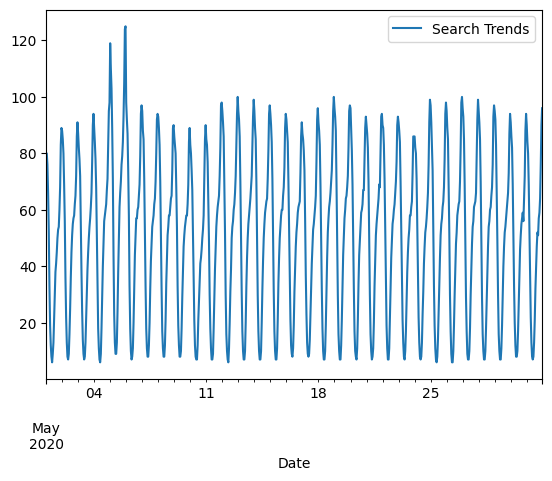

In [5]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05']

# Plot to visualize the data for May 2020
df_may_2020.plot()

# This chart reveals two things of interest:
#  1. there is a weekly ebb and flow of traffic with a high point midweek and the low point at the weekend.
#  2. there is an unusual bump in traffic on May 5th and 6th

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020.sum()

# View the traffic_may_2020 value
traffic_may_2020

Search Trends    38181
dtype: int64

In [7]:
# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions

median_monthly_traffic = df_mercado_trends['Search Trends'].groupby(by=[df_mercado_trends.index.year,df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
print(f'The median monthly Search Trends over the entire dataset is {median_monthly_traffic}.')

#ask for help on this because i am getting a scalar instead of a dataframe

The median monthly Search Trends over the entire dataset is 35172.5.


In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

# This means that the traffic in May 2020 was 8.55% higher than the median.

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, search traffic was 8.55% higher than usual during the month they released their quarterly financial results.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: xlabel='Date'>

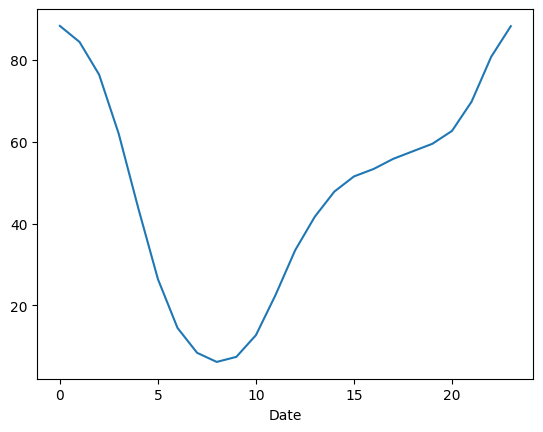

In [9]:
# Group the hourly search data to plot the average traffic by the hour of the day, using `df.index.hour`
df_mercado_trends['Search Trends'].groupby(by=[df_mercado_trends.index.hour]).mean().plot()

# Important to note here that these are UTC times but the users are in the Americas, about 6 hours behind.  So the peak traffic is at around 6 PM
# and the quietest time is near 3 AM.

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='Date'>

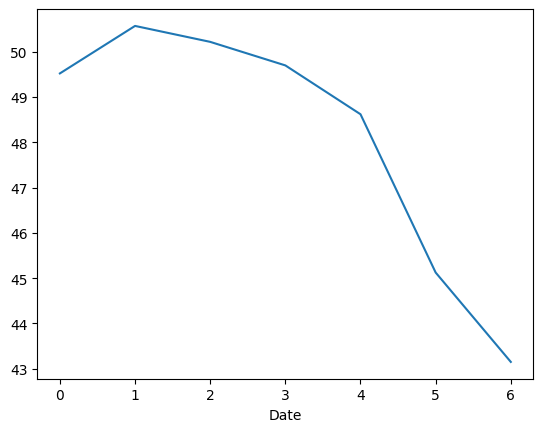

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
df_mercado_trends['Search Trends'].groupby(by=[df_mercado_trends.index.weekday]).mean().plot()

# we see that traffic is highest early in the week (Monday, Tuesday, Wednesday) and drops off on the weekend, with Sunday being the quietest day.
# days of week: 0=Monday... 6=Sunday

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

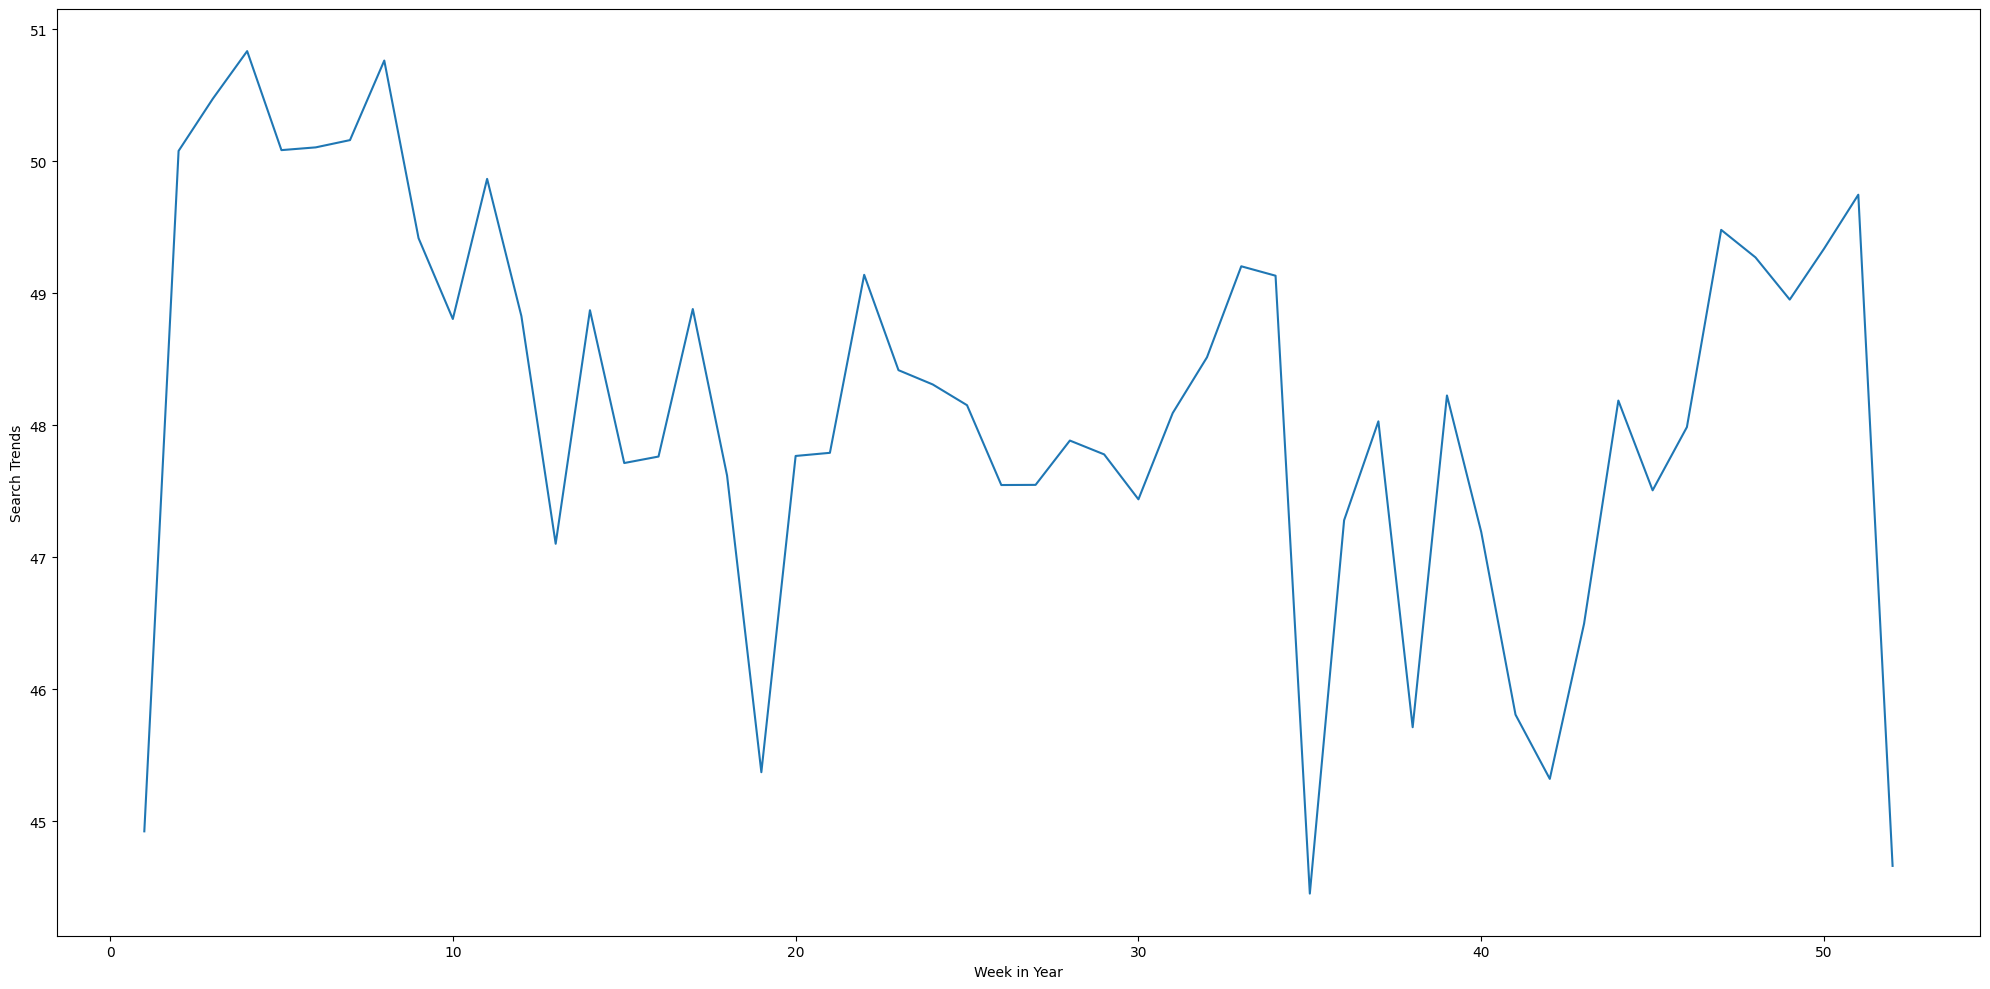

In [11]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
df_mercado_trends['Search Trends'].groupby(by=[df_mercado_trends.index.isocalendar().week]).mean().plot(figsize=[20,10])
#meanval = df_mercado_trends['Search Trends'].groupby(by=[df_mercado_trends.index.isocalendar().week]).mean().mean()

plt.ylabel('Search Trends')
plt.xlabel('Week in Year')

plt.tight_layout()
plt.show()

# we see some variation in traffic across the year, about 6% above and below the mean of about 48
# The lows could be associated with major holidays, such as the dip around New Year's Day.  I compared the peaks and troughs to dates of major holidays
# in Latin America, but I did not detect a clear pattern.


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** There is a boost in traffic during the winter holiday period at the end of the year.  There are several other peaks and lows, but I was not able to line these up with public holidays.
Tuesdays are a peak time, Sundays being lowest.
Busiest hours of the day are evening, and lowest in the early hours of the morning in Latin America.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [12]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=["date"]
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


In [13]:
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00+00:00 to 2020-09-08 00:00:00+00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: xlabel='date'>

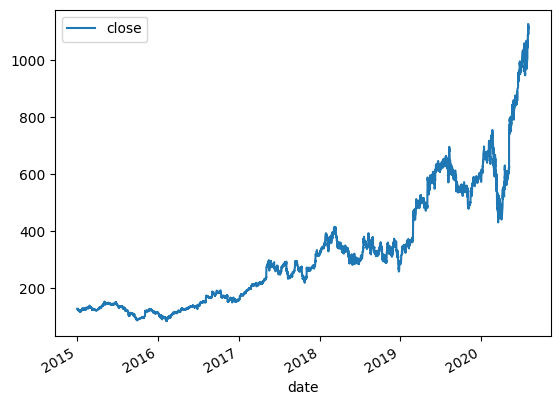

In [14]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.plot()

In [15]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data

# pandas will not concat dataframes having datetime indexes, of which one is time-zone aware
# and one is not.  So these commands will make dfs "time zone naive" (credit to colab built-in AI)
df_mercado_stock = df_mercado_stock.tz_localize(None)
df_mercado_trends = df_mercado_trends.tz_localize(None)

mercado_stock_trends_df = pd.concat([df_mercado_stock,df_mercado_trends],axis=1,join='outer').dropna()
#... so that they can be merged, column-wise.

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [16]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020_DataFrame = mercado_stock_trends_df.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020_DataFrame.head())
display(first_half_2020_DataFrame.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


<Axes: >

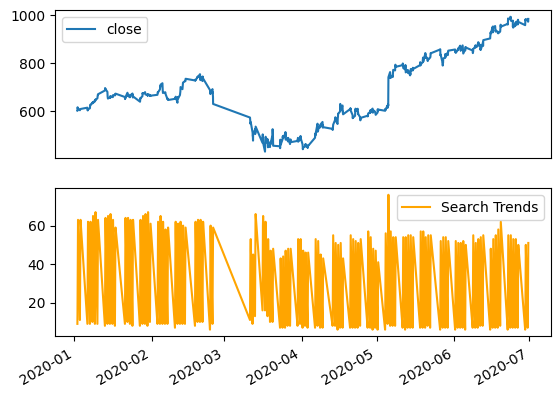

In [17]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
fig, axes = plt.subplots(nrows=2,ncols=1)
first_half_2020_DataFrame[['close']].plot(ax = axes[0],xticks=[])
first_half_2020_DataFrame[['Search Trends']].plot(ax = axes[1],color="orange")

# These plots show the same gap in values during the first weeks of March

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The narrative focuses on a negative shock early in the year, followed by a period of strong growth.  
The Close prices were steady at first, then dropped hard (the "shock") but then began a strong climb upwards, consistent with the narrative.  
The Search Trends did not follow the same pattern.  Search activity was strongest early in the year, weathered the "shock" with a relatively minor drop, but did not show a strong upward trend in the same way the stock price did.
So the data don't support the narrative for the Search Trend data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [18]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)

# verify that it worked...
mercado_stock_trends_df[['Search Trends','Lagged Search Trends']]

,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,6.0,NaN
2016-06-01 10:00:00,12.0,6.0
2016-06-01 11:00:00,22.0,12.0
2016-06-01 12:00:00,33.0,22.0
2016-06-01 13:00:00,40.0,33.0
...,...,...
2020-07-31 11:00:00,20.0,11.0
2020-07-31 12:00:00,32.0,20.0
2020-07-31 13:00:00,41.0,32.0
2020-07-31 14:00:00,47.0,41.0


In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()

mercado_stock_trends_df.head(10)

,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134
2016-06-01 14:00:00,137.03,45.0,40.0,0.004137
2016-06-01 15:00:00,136.27,48.0,45.0,0.005257
2016-06-02 09:00:00,136.00,7.0,48.0,0.005309
2016-06-02 10:00:00,136.83,14.0,7.0,0.006091
2016-06-02 11:00:00,136.22,24.0,14.0,0.005265


<Axes: >

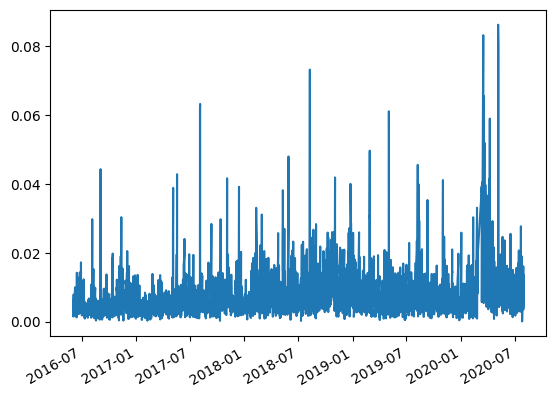

In [20]:
# Visualize the stock volatility
mercado_stock_trends_df['Stock Volatility'].plot()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [21]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


In [22]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head(5))
display(mercado_stock_trends_df.tail(5))

# Looks good

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [23]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** There is a very small (insignificant?) negative correlation between lagged search traffic and stock volatility (-0.14)
There is also a very small positive correlation between lagged search traffic and stock price return (0.06).
Both are very weak correlations.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [24]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()
#display(prophet_df.head())
#display(df_mercado_trends.head())

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df.columns = ['ds','y']
#display(prophet_df.head())

# Drop an NaN values from the prophet_df DataFrame
prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(prophet_df.head())
display(prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [25]:
# Call the Prophet function, store as an object
m = Prophet()

In [26]:
# Fit the time-series model.
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7k3i44c/911uygj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7k3i44c/bb43libh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58579', 'data', 'file=/tmp/tmpm7k3i44c/911uygj4.json', 'init=/tmp/tmpm7k3i44c/bb43libh.json', 'output', 'file=/tmp/tmpm7k3i44c/prophet_modelupbmgicz/prophet_model-20240510032100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = m.make_future_dataframe(periods=2000,freq="H")

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail(5)

# Takes us all the way out to november 2020

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [28]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = m.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,80.892534,97.672016,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.598299,94.180139,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.460515,83.637027,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.957984,68.238315,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.284993,51.935126,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

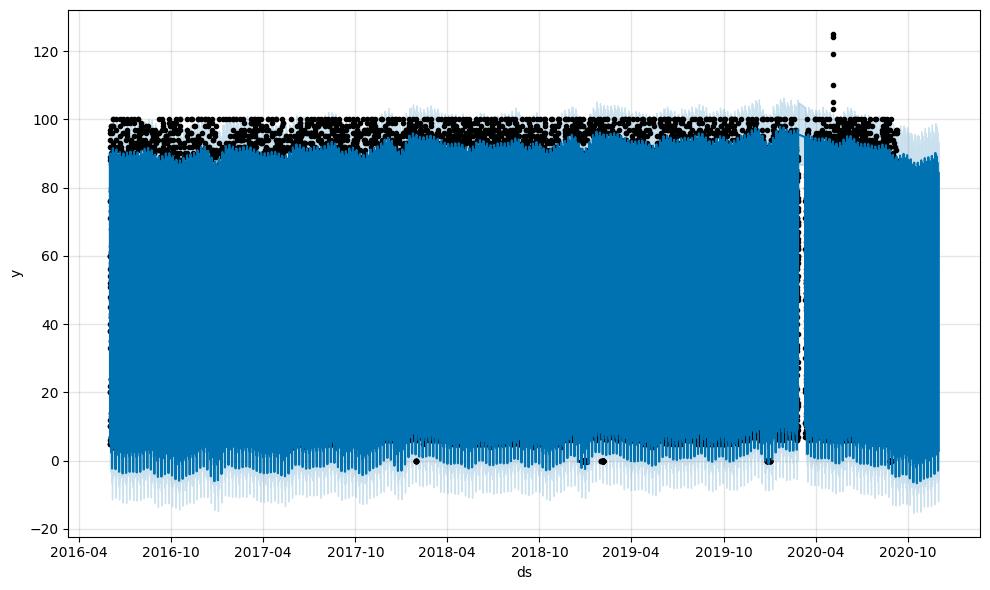

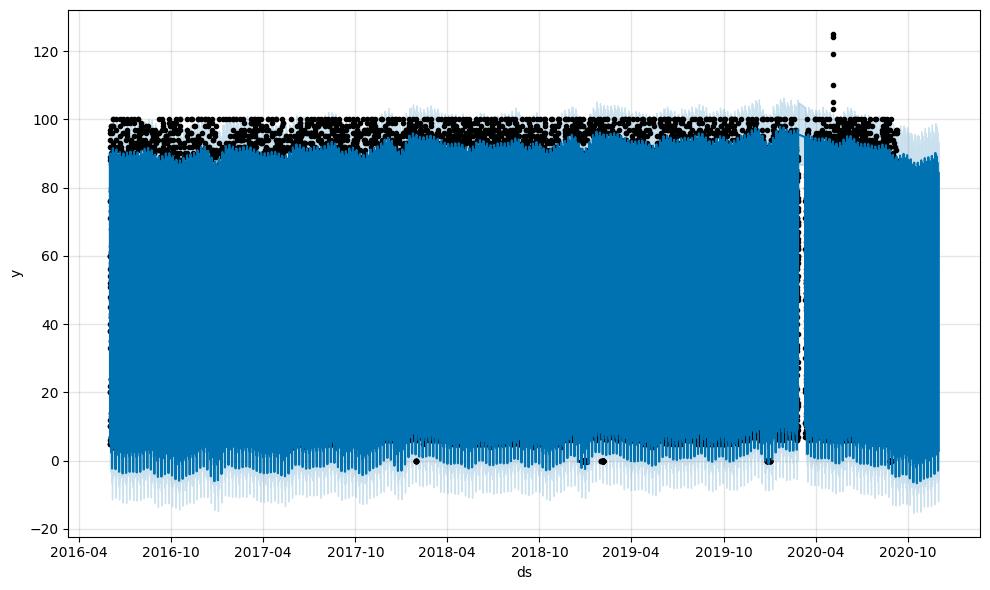

In [29]:
# Plot the Prophet predictions for the Mercado trends data
m.plot(forecast_mercado_trends)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**  The important part of this confusing chart is the far right section without any black dots.  The trend appears to continue to fall and then it turns the corner and comes back up.

In short, mercado search trends will continue to taper for about one month, but then bounce back up to roughly current levels.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [30]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds',inplace=True)

forecast_mercado_trends.info()
# confirmed that the index is set correctly

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39106 entries, 2016-06-01 00:00:00 to 2020-11-30 08:00:00
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   trend                       39106 non-null  float64
 1   yhat_lower                  39106 non-null  float64
 2   yhat_upper                  39106 non-null  float64
 3   trend_lower                 39106 non-null  float64
 4   trend_upper                 39106 non-null  float64
 5   additive_terms              39106 non-null  float64
 6   additive_terms_lower        39106 non-null  float64
 7   additive_terms_upper        39106 non-null  float64
 8   daily                       39106 non-null  float64
 9   daily_lower                 39106 non-null  float64
 10  daily_upper                 39106 non-null  float64
 11  weekly                      39106 non-null  float64
 12  weekly_lower                39106 non-null  float64
 

<Axes: xlabel='ds'>

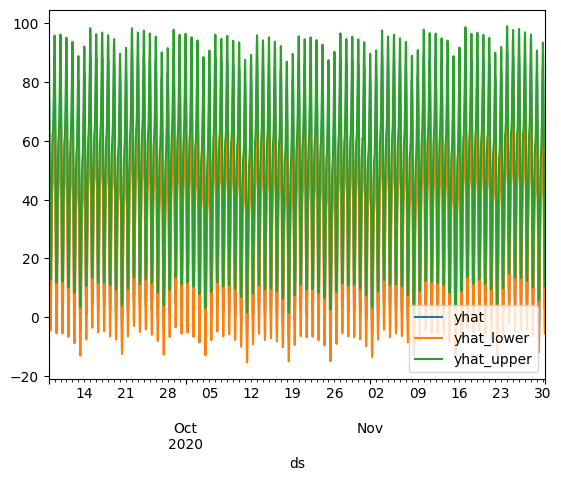

In [31]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:,:].plot()

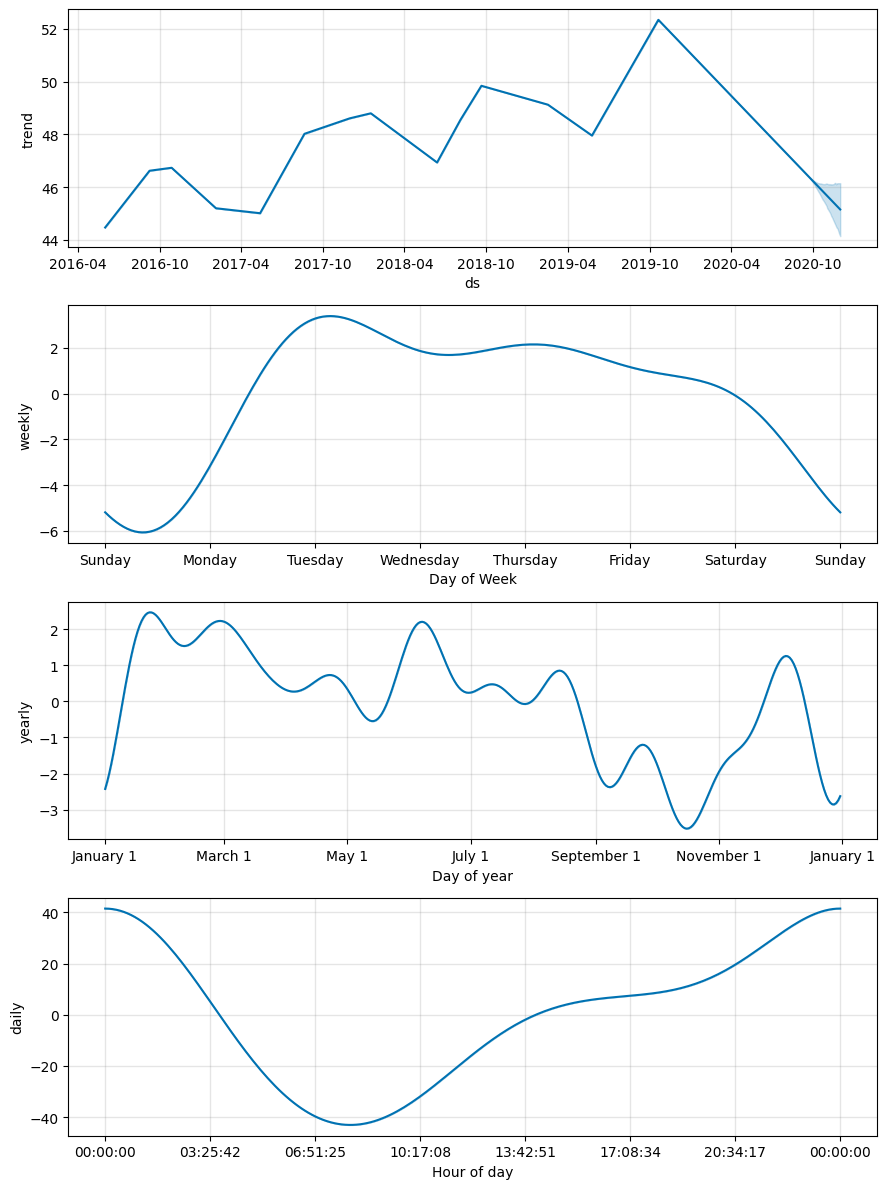

In [32]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
fig_mercado = m.plot_components(forecast_mercado_trends)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Again, these are UTC times but the users are in the Americas, about 6 hours behind.  So the chart shows a high at 00:00, which is 6PM, and the low is at around 3 AM for most users.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday get the most traffic.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Mid October is the lowest point in the year for search traffic.  This does not seem to line up with any public or religious holidays, so why this is a low, I can't tell.
